## importing liberaries

In [281]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
import logging

### importing dataset

In [282]:
df = pd.read_excel("/content/WAR data set.xlsx")
df.head()

,Temprature(℃),PH,CaCl₂ (mol/L),Soaking Time (days),Converted Enzyme Conc (g/L),Urea Conc (g/L),Water Absorption reduction (%)
0,35,9.5,0.147273,3,33.944,20.0,15.0
1,25,8.2,0.050909,3,25.458,20.0,8.0
2,30,9.5,0.550000,3,33.944,20.0,22.0
3,30,9.5,0.550000,7,33.944,20.0,27.3
4,30,9.5,0.550000,10,33.944,20.0,28.6


# dependent and independent variables

In [283]:
X = df.drop('Water Absorption reduction (%)', axis = 1)
y = df['Water Absorption reduction (%)']

In [284]:
# Train _Test Split
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=64)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=64)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training set size: 96
Testing set size: 13
Validation set size: 12


# Standardization

In [285]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform (X)
X=pd.DataFrame(X,columns=['Temprature(℃)','PH', 'CaCl₂ (mol/L)', 'Soaking Time (days)', 'Converted Enzyme Conc (g/L)', 'Urea Conc (g/L)	'])
X.head()


,Temprature(℃),PH,CaCl₂ (mol/L),Soaking Time (days),Converted Enzyme Conc (g/L),Urea Conc (g/L)\t
0,0.816466,1.296392,-1.176596,-0.444484,-0.483277,-0.764817
1,-0.524001,0.083290,-1.483405,-0.444484,-1.968972,-0.764817
2,0.146233,1.296392,0.105635,-0.444484,-0.483277,-0.764817
3,0.146233,1.296392,0.105635,0.433599,-0.483277,-0.764817
4,0.146233,1.296392,0.105635,1.092162,-0.483277,-0.764817


In [286]:
def add_noise(data, noise_factor=0.05, num_samples=96, random_state=42):
    augmented_data = []
    np.random.seed(random_state)
    for _ in range(num_samples):
        random_index = np.random.randint(0, len(data))
        sample = data.iloc[random_index]
        noise = np.random.randn(data.shape[1]) * noise_factor
        augmented_sample = sample + noise
        augmented_data.append(augmented_sample)

    augmented_data = pd.DataFrame(augmented_data, columns=data.columns)
    return augmented_data

X_train_augmented = add_noise(X_train, num_samples=96, random_state=42)
y_train_augmented = y_train.iloc[np.random.choice(len(y_train), 96, replace=False)]

X_train_combined = pd.concat([X_train, X_train_augmented], ignore_index=True)
y_train_combined = pd.concat([y_train, y_train_augmented], ignore_index=True)

print(f"Original training set size (Noise Injection): {X_train.shape[0]}")
print(f"Augmented training set size (Noise Injection): {X_train_augmented.shape[0]}")
print(f"Combined training set size (Noise Injection): {X_train_combined.shape[0]}")

print("\nShapes after noise injection augmentation:")
print(f"Shape of X_train_combined: {X_train_combined.shape}")
print(f"Shape of y_train_combined: {y_train_combined.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")

Original training set size (Noise Injection): 96
Augmented training set size (Noise Injection): 96
Combined training set size (Noise Injection): 192

Shapes after noise injection augmentation:
Shape of X_train_combined: (192, 6)
Shape of y_train_combined: (192,)
Shape of X_test: (13, 6)
Shape of y_test: (13,)
Shape of X_val: (12, 6)
Shape of y_val: (12,)


## Decission tree model

In [287]:
from sklearn.tree import DecisionTreeRegressor
DTR = DecisionTreeRegressor(criterion=('squared_error'), max_depth=4, min_samples_split=2, max_features=2, random_state=40)

In [288]:
DTR.fit(X_train_combined,y_train_combined)

DecisionTreeRegressor(max_depth=4, max_features=2, random_state=40)

In [289]:
DTR.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 4,
 'max_features': 2,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 40,
 'splitter': 'best'}

In [290]:
y_pred_train = DTR.predict(X_train_combined)
y_pred_test = DTR.predict(X_test)
y_pred_val=DTR.predict(X_val)


### Evaluating Model

In [291]:
from math import sqrt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [292]:
# Evaluate on the training set
print("Training Set Metrics:")
print(f'The RMSE on the training dataset is: {sqrt(mean_squared_error(y_train, DTR.predict(X_train))):.4f}')
print(f'The MSE on the training dataset is: {(mean_squared_error(y_train, DTR.predict(X_train))):.4f}')
print(f'The MAE on the training daset is: {mean_absolute_error(y_train, DTR.predict(X_train)):.4f}')
print(f'The r2_score on the training dataset is: {r2_score(y_train, DTR.predict(X_train)):.4f}')
print("-" * 30)

# Evaluate on the testing set
print("Testing Set Metrics:")
print(f'The RMSE on the testing dataset is: {sqrt(mean_squared_error(y_test, DTR.predict(X_test))):.4f}')
print(f'The MSE on the testing dataset is: {(mean_squared_error(y_test, DTR.predict(X_test))):.4f}')
print(f'The MAE on the testing dataset is: {mean_absolute_error(y_test, DTR.predict(X_test)):.4f}')
print(f'The r2_score on the testing dataset is: {r2_score(y_test, DTR.predict(X_test)):.4f}')
print("-" * 30)

# Evaluate on the validation set
print("Validation Set Metrics:")
print(f'The RMSE on the validation dataset is: {sqrt(mean_squared_error(y_val, DTR.predict(X_val))):.4f}')
print(f'The MSE on the validation dataset is: {(mean_squared_error(y_val, DTR.predict(X_val))):.4f}')
print(f'The MAE on the validation dataset is: {mean_absolute_error(y_val, DTR.predict(X_val)):.4f}')
print(f'The r2_score on the validation dataset is: {r2_score(y_val, DTR.predict(X_val)):.4f}')

Training Set Metrics:
The RMSE on the training dataset is: 7.0723
The MSE on the training dataset is: 50.0173
The MAE on the training daset is: 5.4419
The r2_score on the training dataset is: 0.7664
------------------------------
Testing Set Metrics:
The RMSE on the testing dataset is: 4.3223
The MSE on the testing dataset is: 18.6819
The MAE on the testing dataset is: 3.4254
The r2_score on the testing dataset is: 0.9370
------------------------------
Validation Set Metrics:
The RMSE on the validation dataset is: 6.9778
The MSE on the validation dataset is: 48.6904
The MAE on the validation dataset is: 4.6918
The r2_score on the validation dataset is: 0.8641


### hyperparameter tunning  (optimization)

In [293]:
from sklearn.model_selection import GridSearchCV

In [294]:
param = { 'criterion':['squared_error', 'absolute_error'],
          'splitter':['best'],
          'max_depth':range(2,25),
          'max_features':range(1,6),
          'min_samples_split': range(1,10),
          'min_samples_leaf': range(1,2)
                    }

In [295]:
gcv=GridSearchCV(estimator=DTR ,param_grid=param ,n_jobs=-1,cv=10)

In [296]:
gcv.fit(X_train_combined ,y_train_combined)

GridSearchCV(cv=10,
             estimator=DecisionTreeRegressor(max_depth=4, max_features=2,
                                             random_state=40),
             n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': range(2, 25), 'max_features': range(1, 6),
                         'min_samples_leaf': range(1, 2),
                         'min_samples_split': range(1, 10),
                         'splitter': ['best']})

In [297]:
gcv.best_params_

{'criterion': 'squared_error',
 'max_depth': 4,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'splitter': 'best'}

In [298]:
y_pred_train = gcv.predict(X_train_combined)
y_pred_test = gcv.predict(X_test)
y_pred_val=gcv.predict(X_val)

### Evaluating The optimized model

In [299]:
from math import sqrt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [300]:
# Evaluate on the training set
print("Training Set Metrics:")
print(f'The RMSE on the training dataset is: {sqrt(mean_squared_error(y_train_combined, gcv.predict(X_train_combined))):.4f}')
print(f'The MSE on the training dataset is: {(mean_squared_error(y_train_combined, gcv.predict(X_train_combined))):.4f}')
print(f'The MAE on the training daset is: {mean_absolute_error(y_train_combined, gcv.predict(X_train_combined)):.4f}')
print(f'The r2_score on the training dataset is: {r2_score(y_train_combined, gcv.predict(X_train_combined)):.4f}')
print("-" * 30)

# Evaluate on the testing set
print("Testing Set Metrics:")
print(f'The RMSE on the testing dataset is: {sqrt(mean_squared_error(y_test, gcv.predict(X_test))):.4f}')
print(f'The MSE on the testing dataset is: {(mean_squared_error(y_test, gcv.predict(X_test))):.4f}')
print(f'The MAE on the testing dataset is: {mean_absolute_error(y_test, gcv.predict(X_test)):.4f}')
print(f'The r2_score on the testing dataset is: {r2_score(y_test, gcv.predict(X_test)):.4f}')
print("-" * 30)

# Evaluate on the validation set
print("Validation Set Metrics:")
print(f'The RMSE on the validation dataset is: {sqrt(mean_squared_error(y_val, gcv.predict(X_val))):.4f}')
print(f'The MSE on the validation dataset is: {(mean_squared_error(y_val, gcv.predict(X_val))):.4f}')
print(f'The MAE on the validation dataset is: {mean_absolute_error(y_val, gcv.predict(X_val)):.4f}')
print(f'The r2_score on the validation dataset is: {r2_score(y_val, gcv.predict(X_val)):.4f}')

Training Set Metrics:
The RMSE on the training dataset is: 9.6413
The MSE on the training dataset is: 92.9547
The MAE on the training daset is: 7.1770
The r2_score on the training dataset is: 0.5659
------------------------------
Testing Set Metrics:
The RMSE on the testing dataset is: 4.3223
The MSE on the testing dataset is: 18.6819
The MAE on the testing dataset is: 3.4254
The r2_score on the testing dataset is: 0.9370
------------------------------
Validation Set Metrics:
The RMSE on the validation dataset is: 6.9778
The MSE on the validation dataset is: 48.6904
The MAE on the validation dataset is: 4.6918
The r2_score on the validation dataset is: 0.8641


#DT graph

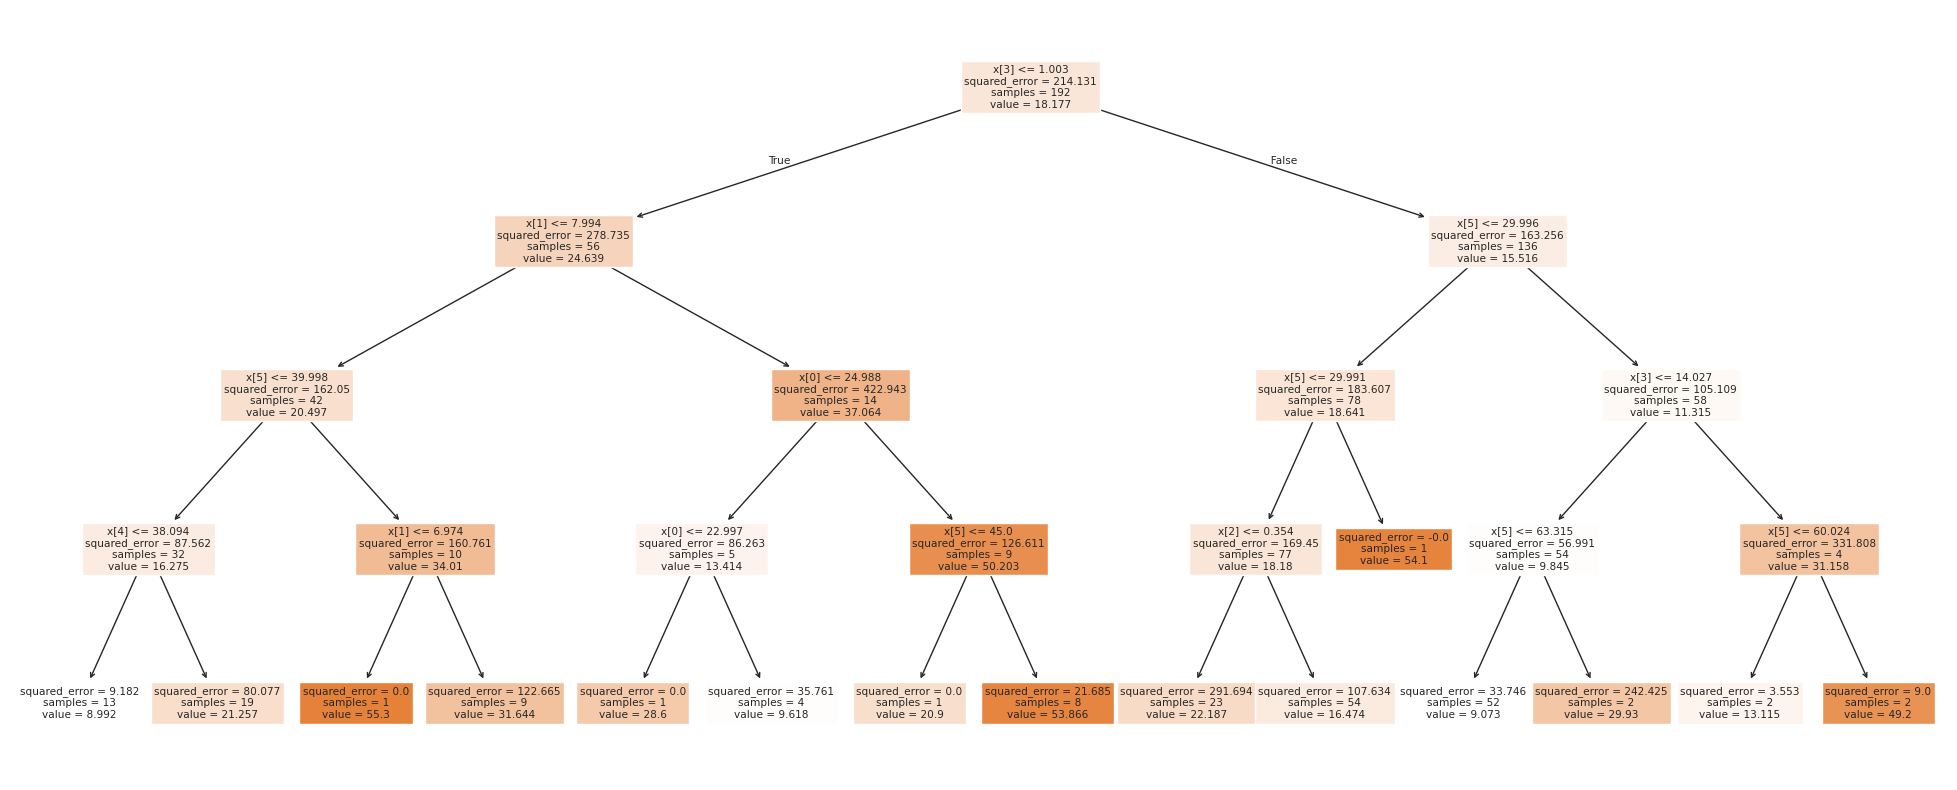

In [301]:
from sklearn.tree import plot_tree
plt.figure(figsize =(25,10))
fontsize=50
max_depth=19
plot_tree(gcv.best_estimator_,filled = True)
plt.show()

### Feature importace for DT regression

In [302]:
gcv.best_estimator_.feature_importances_

array([0.19937652, 0.14551305, 0.02262652, 0.21459616, 0.04990774,
       0.36798   ])

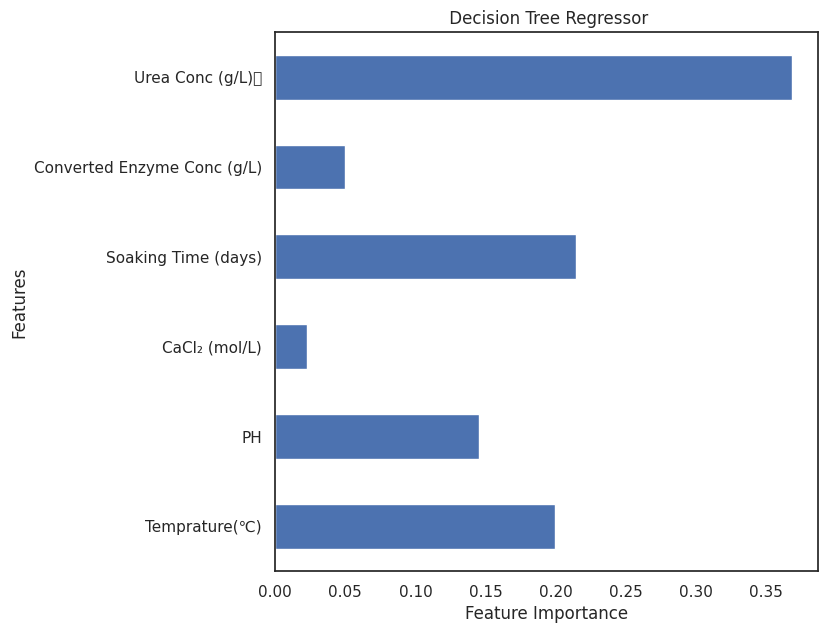

In [303]:
importances = pd.Series(gcv.best_estimator_.feature_importances_ , index=X.columns)
sns.set_style('white')
importances.plot(kind = 'barh', figsize=(7,7))
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title(" Decision Tree Regressor")
plt.show()

### Actual Vs Predicted Capacity

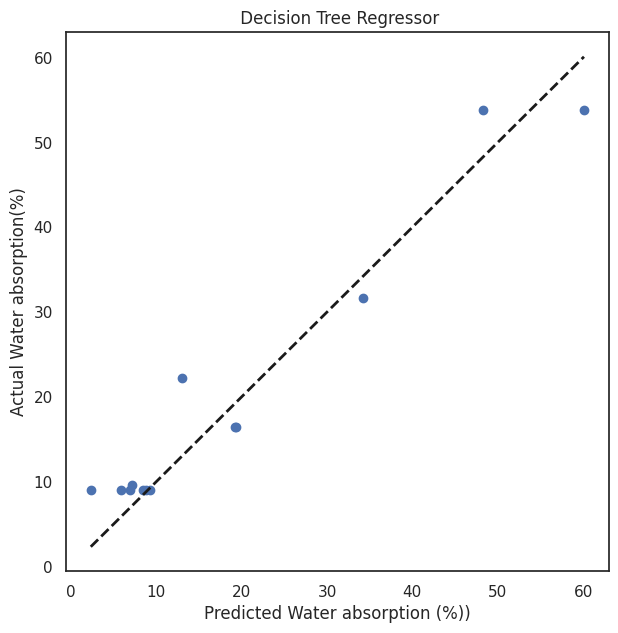

In [304]:
plt.figure(figsize=(7,7))
sns.set_style("white")
plt.xlabel("Predicted Water absorption (%))")
plt.ylabel("Actual Water absorption(%)")
plt.title(" Decision Tree Regressor")
plt.scatter(y_test,y_pred_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()